In [1]:
import sys
sys.path.append("..")

In [2]:
from inpainting.data.datasets import InpaintingDataset
from inpainting.models.text_to_image import FreestyleStableDiffusionInpaintPipeline
import torch
from tqdm import tqdm
from torchvision.transforms import GaussianBlur
from torchvision.transforms.functional import to_pil_image
import lovely_tensors as lt
from einops import repeat
lt.monkey_patch()

/leonardo/home/userexternal/nfanelli/miniconda3/envs/vitart/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/leonardo/home/userexternal/nfanelli/miniconda3/envs/vitart/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/leonardo/home/userexternal/nfanelli/miniconda3/envs/vitart/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.i

In [3]:
pipe_freestyle = FreestyleStableDiffusionInpaintPipeline.from_pretrained(
    "../models/stable-diffusion-2-inpainting",
    torch_dtype=torch.bfloat16,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/leonardo/home/userexternal/nfanelli/miniconda3/envs/vitart/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


In [4]:
freestyle_dataset = InpaintingDataset(
    data_dir="../data/mm_inp_dataset",
    tokenizer=pipe_freestyle.tokenizer,
    max_concepts=5,
    generator=torch.Generator(),
    shuffle_concepts=True,
    masked_area_threshold=0.65,
    resolution=512,
    freestyle=True,
    drop_caption_probability=0.0,
    texts_dir="../models/llava/multimask_dci/preds",
    split="test",
)

In [5]:
freestyle_dataloader = torch.utils.data.DataLoader(
    dataset=freestyle_dataset,
    num_workers=8,
    batch_size=8,
    shuffle=False,
    worker_init_fn=lambda worker_id: freestyle_dataset.generator.manual_seed(
            42 + worker_id
    ),
    collate_fn=InpaintingDataset.collate_fn
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
example_clip_refs = []
for i, batch in enumerate(tqdm(freestyle_dataloader)):
        pixel_values = batch["pixel_values"].to(device)

        all_masks = batch["all_masks"]
        texts = batch["gt_texts"]

        # from [-1, 1] to [0, 1]
        pixel_values_01 = (pixel_values * 0.5) + 0.5
        gaussian_blur = GaussianBlur(kernel_size=15, sigma=20)


        # compute per-image/per-mask clip scores
        for j, example_masks in enumerate(all_masks):
            example_clip_preds = []
            example_clip_refs = []
            for mask in example_masks:
                # mask is in [0, 1] of shape [1, 512, 512], we reduce the brightness of the background using the mask
                mask = mask.to(device)

                pixel_values_to_edit = pixel_values_01[j]

                # reduce intensity of pixel_values_to_edit to 0.1
                pixel_values_to_edit = pixel_values_to_edit * 0.1

                # gaussian blur the pixel_values_to_edit
                pixel_values_to_edit = gaussian_blur(pixel_values_to_edit)

                # put the fg_pixel_values back
                fg_mask = repeat((mask > 0).squeeze(0), "h w -> c h w", c=3)
                pixel_values_to_edit[fg_mask] = pixel_values_01[j][fg_mask]

                example_clip_refs.append(pixel_values_to_edit)

0it [00:00, ?it/s]


In [10]:
image = to_pil_image(example_clip_refs[0])

IndexError: list index out of range

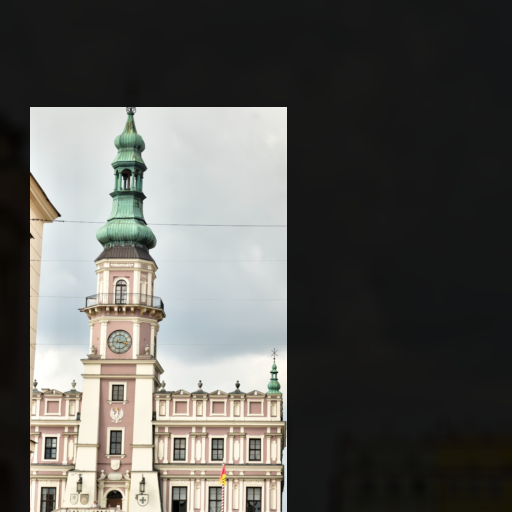

In [ ]:
image

In [ ]:
from transformers import CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


/leonardo/home/userexternal/nfanelli/miniconda3/envs/vitart/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
texts = ["a padded image of a tower", "a padded image of a tower, with the sky in the background", "a padded image of a cat", "a padded image of a dog", "a padded image of a car", "a padded image of a tree"]

In [ ]:
with torch.no_grad():
    text_embeddings = processor(texts, return_tensors="pt", padding=True).input_ids
    text_embeddings = model.get_text_features(text_embeddings)
    text_embeddings
    image_embeddings = processor(images=image, return_tensors="pt").pixel_values
    image_embeddings = model.get_image_features(image_embeddings)
    image_embeddings

In [ ]:
# compute cosine similarity between text and image embeddings
cosine_similarity = torch.nn.functional.cosine_similarity(text_embeddings, image_embeddings, dim=-1)
cosine_similarity

tensor[6] x∈[0.182, 0.270] μ=0.219 σ=0.038 [0.264, 0.270, 0.182, 0.193, 0.197, 0.210]